In [52]:
import mido
import string
import numpy as np
import scipy
#mid = mido.MidiFile('.mid', clip=True)
mid = mido.MidiFile('funk.mid', clip=True)
for i in range(0, len(mid.tracks[0])):
    print(mid.tracks[0][i])

<meta message time_signature numerator=4 denominator=4 clocks_per_click=24 notated_32nd_notes_per_beat=8 time=0>
<meta message key_signature key='C' time=0>
<meta message set_tempo tempo=357142 time=0>
<meta message set_tempo tempo=357142 time=8192>
<meta message time_signature numerator=5 denominator=4 clocks_per_click=24 notated_32nd_notes_per_beat=8 time=39936>
<meta message time_signature numerator=4 denominator=4 clocks_per_click=24 notated_32nd_notes_per_beat=8 time=1280>
<meta message end_of_track time=1>


In [53]:
def convert_clocks_per_click(clocks_per_click, user_tempo):
    sec_per_click = .6 / (user_tempo * clocks_per_click)
    return sec_per_click

In [54]:
def convert_velocity(midi_vel):
    velocity = midi_vel / 127.0
    return velocity

In [55]:
def convert_frequency(midi_val):
    reference = 440
    frequency = (reference / 32) * (2 ** ((midi_val - 9) / 12))
    return frequency

In [56]:
def parse_MIDI(midi_file, user_tempo):
    # ticks_per_quarter = <PPQ from the header>
    # µs_per_quarter = <Tempo in latest Set Tempo event>
    # µs_per_tick = µs_per_quarter / ticks_per_quarter
    # seconds_per_tick = µs_per_tick / 1.000.000
    # seconds = ticks * seconds_per_tick
    clocks_per_click = 0
    midi_info = []
    note_value = 0
    note_velocity = 0
    note_dur = 0
    sec_per_click = 0
    curr_message = ''
    prev_message = ''


    mid = mido.MidiFile(midi_file, clip=True)
    for i in range(0, len(mid.tracks)):
        for m in mid.tracks[i][:]:
            print(m)
            m = str(m)
            if 'clocks_per_click' in m:
                # midi.append(m)
                temp = m.partition("clocks_per_click=")[2]
                clocks_per_click = temp.partition(" ")[0]
                #sec_per_click = convert_clocks_per_click(int(clocks_per_click), user_tempo)
            if 'note_on' in m:
                curr_message = 'note_on'
                if curr_message != prev_message:
                    temp = m.partition("note=")[2]
                    note_value = temp.partition(" ")[0]
                    #convert to frequency
                    note_value = convert_frequency(int(note_value))
                    temp = m.partition("velocity=")[2]
                    note_velocity = temp.partition(" ")[0]
                    #convert to 0-1 amplitude
                    note_velocity = convert_velocity(int(note_velocity))
                    
                    # rests
                
                    note_dur = m.partition("time=")[2]
                    #convert to seconds
                    #note_dur = sec_per_click * int(note_dur)
                    note_dur = mido.tick2second(int(note_dur), int(clocks_per_click), mido.bpm2tempo(user_tempo))
                    if note_dur > 0:
                        midi_info.append((440, 0, note_dur))
                    #print(midi_info)

            if 'note_off' in m:
                curr_message = 'note_off'
                if curr_message != prev_message:
                    note_dur = m.partition("time=")[2]
                    #convert to seconds
                    #note_dur = sec_per_click * int(note_dur)
                    note_dur = mido.tick2second(int(note_dur), int(clocks_per_click), mido.bpm2tempo(user_tempo))
                    if note_dur > 0:
                        midi_info.append((note_value, note_velocity, note_dur))
                    #print(midi_info)

            prev_message = curr_message
    return midi_info

In [57]:
note_list = parse_MIDI('scale.mid', 120)

<meta message time_signature numerator=4 denominator=4 clocks_per_click=24 notated_32nd_notes_per_beat=8 time=0>
<meta message key_signature key='C' time=0>
<meta message set_tempo tempo=250000 time=0>
<meta message copyright text='Copyright © ' time=0>
<meta message time_signature numerator=10 denominator=4 clocks_per_click=24 notated_32nd_notes_per_beat=8 time=38400>
<meta message time_signature numerator=6 denominator=4 clocks_per_click=72 notated_32nd_notes_per_beat=8 time=9600>
<meta message end_of_track time=1>
program_change channel=0 program=0 time=0
control_change channel=0 control=121 value=0 time=0
control_change channel=0 control=64 value=0 time=0
control_change channel=0 control=91 value=48 time=0
control_change channel=0 control=10 value=51 time=0
control_change channel=0 control=7 value=100 time=0
<meta message track_name name='Piano' time=0>
pitchwheel channel=0 pitch=0 time=0
<meta message lyrics text='1/1 ' time=0>
note_on channel=0 note=60 velocity=76 time=0
note_off

In [58]:
def genSine(frequency, duration, amplitude = 1, sampleRate = 48000, phase = 0):
    
    #creates a sine wave
    
    import numpy as np
    
    time = np.arange(0, duration, 1/sampleRate)
    return amplitude * np.sin((2*np.pi * frequency * time) + phase)

In [59]:
def adsr(x,a=.25,d=.25,s=.25,r=.25,fs=48000):
    total_len = len(x)
    a_len = int(.25 * len(x))
    d_len = int(.25 * len(x))
    r_len = int(.25 * len(x))
    s_len = int(len(x) - a_len - d_len - r_len)
    # s_len = int(.25 * len(x))

    xa= np.arange(0, a_len)                                                     #sets up size of attack portion
    ya= np.linspace(0,np.max(x),xa.size)                                       #creates attack envelope

    xd= np.arange(a_len, a_len+d_len)                                                 #sets up size of decay portion
    yd= np.linspace(np.max(x),.5,xd.size)                                        #creates attack envelope

    xs= np.arange(a_len+d_len, a_len+d_len+s_len)                               #sets up size of sustain portion
    ys= np.linspace(.5,.5,xs.size)                                            #creates sustain envelope

    xr= np.arange(a_len+d_len+s_len, a_len+d_len+s_len+r_len)               #sets up size of release portion
    yr= np.linspace(.5,0,xr.size)

    env=np.concatenate((ya,yd,ys,yr))                                          #creates full adsr envelope array
    adsrnote=x*env[0:x.size]               
                                               #applies adsr envelope to input array
    return adsrnote

In [60]:
def lfo(x, freq, amplitude=1, fs=48000):
    t = np.arange(0,len(x)/fs,1/fs)
    lfo = x * amplitude * np.cos(2*np.pi*freq*t)
    return lfo

In [61]:
def reverb(x, impulse):
    fft_sig = scipy.fft.fft(x)
    fft_impulse = scipy.fft.fft(impulse)
    conv = fft_impulse * fft_sig
    return scipy.fft.ifft(conv)
    
    # from scipy.io.wavfile import read

    # fs, impulse = read('St Nicolaes Church.wav')
    # impulse = np.transpose(impulse)[0]

    # impulse = np.concatenate((impulse, np.zeros(len(play_list)-len(impulse))))
    # impulse = impulse / np.max(impulse)
    # play_list = np.real(reverb(play_list, impulse))


In [62]:
#function that applies a low-pass filter
#x is the original signal
#cutoff is the cutoff frequency
#order is the order of the filter
def lowpass(x, cutoff=440, order=10, fs=48000):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq

    from scipy.signal import butter, filtfilt

    (b,a) = butter(order, normal_cutoff, btype = 'low', analog = False)
    filt_sig = filtfilt(b,a,x)
    
    return filt_sig

In [63]:
def flanger(x, delay_time=0.003, rate=.1, feedback_percent=.5, fs=48000):
    import math
    ind = np.arange(0, len(x))
    sine_osc = np.sin(2 * np.pi * ind * (rate/fs))
    delay_samples = int(delay_time*fs)
    x_zero = np.zeros(len(x))
    x_zero[:delay_samples] = x[:delay_samples]
    for i in range(delay_samples, len(x)):
        abs_sin = abs(sine_osc[i])
        cur_delay = math.ceil(abs_sin*delay_samples)
        x_zero[i] = (feedback_percent * x[i]) + (feedback_percent * x[i-cur_delay])
    return x_zero

In [64]:
def wahwah(x, damping=0.05, min_freq=250, max_freq=5000, wah_freq=1000, fs=48000):
    freq_change = wah_freq/fs
    center_freq = np.arange(min_freq, max_freq, freq_change)
    #create triangle wave of center frequencies
    while len(center_freq) < len(x):
        center_freq = center_freq[np.arange(max_freq,min_freq,-freq_change)]
        center_freq = center_freq[np.arange(min_freq,max_freq,freq_change)]
    center_freq = center_freq[0:len(x)]
    # center_freq = np.ndarray.transpose(center_freq)
    print(center_freq)

    freq_coeff = 2 * np.sin((np.pi * center_freq[0]) / fs)
    # print(center_freq)
    q = 2 * damping

    y_high = np.zeros(len(x))
    y_band = np.zeros(len(x))
    y_low = np.zeros(len(x))

    y_high[0] = x[0]
    y_band[0] = freq_coeff * y_high[0]
    y_low[0] = freq_coeff * y_band[0]

    for i in range(1, (len(center_freq))-1):
        y_high[i] = x[i] - y_low[i-1] - (q * y_band[i-1])
        y_band[i] = (freq_coeff * y_high[i]) + y_band[i-1]
        y_low[i] = (freq_coeff * y_band[i]) + y_low[i-1]
        freq_coeff = 2 * np.sin((np.pi * center_freq[i]) / fs)
    
    y_band = y_band / (max(abs(y_band)))
    return y_band


In [65]:
def wavetable(frequency, dur, amp, fs=48000):
    from matplotlib import pyplot as plt
    # choose the wave type
    t = np.arange(0,128/fs,1/fs)
    wave = np.sin(2 * np.pi * 375 * np.arange(0,128/fs,1/fs))

    interp = scipy.interpolate.CubicSpline(np.arange(0, len(wave)), wave,bc_type='natural')

    # plt.plot(t, wave)
    wave = wave / max(wave)
    # frequency to step size
    step = (round(frequency) * 128) / fs
    # time to desired sample length (array length)
    length = dur * fs
    ind_arr = np.arange(0, step * length, step)
    # ind_arr = np.linspace(0, step * length, length)
    out = np.array([])
    #read table
    for i in ind_arr:
        i = i % 128
        if i != int(i):
            # floored = int(i)
            # next = floored + 1
            # decimal = i - floored
            # out = np.append(out, wave[floored] + decimal * (wave[next] - wave[floored]))
            out = np.append(out, interp(i))
        elif i == int(i):
            out = np.append(out, wave[int(i)])
    out = out * amp
    return out


In [66]:
import scipy
from scipy import interpolate

inter = scipy.interpolate.CubicSpline(np.array([0, 1, 2]), np.array([0, 2, 4]),bc_type='natural')
print(inter(1.3))

2.6


In [67]:
def additive(type, freq, duration, num_harmonics, amplitude=1, fs=48000, phase_shift=0):
    summed_wave = np.array([])
    if type == 'sine':
        summed_wave = genSine(freq, duration, phase=(phase_shift))
        for i in range(2, num_harmonics+1):
            add = genSine((freq * i), duration, phase=(phase_shift*i))
            summed_wave = summed_wave + add
    # elif type == 'square':
    #     for i in range(1, num_harmonics+1):
    #         add = genSquare((freq * i), duration, phase=(phase_shift*i))
    #         summed_wave += add
    # elif type == 'triangle':
    #     for i in range(1, num_harmonics+1):
    #         add = genTriangle((freq * i), duration, phase=(phase_shift*i))
    #         summed_wave += add
    # elif type == 'saw':
    #     for i in range(1, num_harmonics+1):
    #         add = genSaw((freq * i), duration, phase=(phase_shift*i))
    #         summed_wave += add
    summed_wave *= amplitude
    summed_wave = summed_wave / np.max(summed_wave)
    return summed_wave

In [68]:
def ring_modulation(x, rate=0.5, blend=0.5, block_size=512):
    remainder = len(x) % block_size
    print(len(x))
    print(remainder)
    pad = np.zeros(remainder)
    print(len(pad))
    x = np.concatenate((x, pad))
    print(len(x))
    print(len(x) / block_size)
    total_blocks = len(x) / block_size
    for j in range(int(total_blocks)):
        t = 0
        for i in range(block_size):
            ring_factor = np.sin(t)
            t += (rate * 0.2)
            x[i + (block_size * j)] = ((1-blend) * x[i + (block_size * j)]) + (blend * ring_factor * x[i + (block_size * j)])
    x = x[0:(len(x)-remainder)]
    return x

In [69]:
sine = note_sine = synth_helpers.wavetable(i[0], i[2], i[1], 'sine')
                    play_list = np.concatenate((play_list, note_sine))
sine = ring_modulation(sine)

IndentationError: unexpected indent (<ipython-input-69-d44b18e71006>, line 2)

In [70]:
from IPython.display import Audio
import scipy
from scipy.io.wavfile import write
write("test.wav", 48000, sine)

NameError: name 'sine' is not defined

In [71]:
print(sine)

NameError: name 'sine' is not defined

In [72]:
note_list

[(261.6255653005986, 0.5984251968503937, 26.666666666666664),
 (293.66476791740763, 0.6062992125984252, 26.666666666666664),
 (311.1269837220809, 0.6062992125984252, 26.666666666666664),
 (329.62755691286986, 0.6062992125984252, 26.666666666666664),
 (349.22823143300394, 0.6062992125984252, 26.666666666666664),
 (369.9944227116344, 0.6062992125984252, 26.666666666666664),
 (391.9954359817492, 0.6062992125984252, 26.666666666666664),
 (440.0, 0.6062992125984252, 26.666666666666664),
 (466.1637615180898, 0.6062992125984252, 26.666666666666664),
 (493.88330125612424, 0.6062992125984252, 26.666666666666664),
 (523.2511306011972, 0.6062992125984252, 40.0),
 (261.6255653005986, 0.5984251968503937, 40.0),
 (329.62755691286986, 0.5984251968503937, 40.0),
 (391.9954359817492, 0.5984251968503937, 40.0)]

In [73]:
note_sine_1 = genSine(523.2511306011972, 2.4, 0.6062992125984252)
note_sine_2 = wavetable(523, 2.4, 0.6062992125984252)
print(len(note_sine_1))
print(len(note_sine_2))


115200
115200


In [74]:
note_list = parse_MIDI('happy_birthday_BPNO.mid', 1)
note_list
mido.tempo2bpm(600000)

<meta message time_signature numerator=3 denominator=4 clocks_per_click=24 notated_32nd_notes_per_beat=8 time=0>
<meta message key_signature key='C' time=0>
<meta message set_tempo tempo=600000 time=0>
<meta message track_name name='Happy Birthday' time=0>
<meta message text text='trad.' time=0>
<meta message time_signature numerator=7 denominator=8 clocks_per_click=12 notated_32nd_notes_per_beat=8 time=17280>
<meta message time_signature numerator=3 denominator=4 clocks_per_click=24 notated_32nd_notes_per_beat=8 time=3360>
<meta message time_signature numerator=2 denominator=4 clocks_per_click=24 notated_32nd_notes_per_beat=8 time=2880>
<meta message end_of_track time=1>
program_change channel=0 program=0 time=1920
control_change channel=0 control=121 value=0 time=0
control_change channel=0 control=64 value=0 time=0
control_change channel=0 control=91 value=48 time=0
control_change channel=0 control=10 value=51 time=0
control_change channel=0 control=7 value=100 time=0
control_change 

100.0

In [75]:
note_list = parse_MIDI('Saw.mid', 160)
play_list = np.array([])
for i in note_list:
    note_sine = genSine(i[0], i[2], i[1])
    #note_sine = wavetable(i[0], i[2], i[1])
    note_sine = adsr(note_sine)
    play_list = np.concatenate((play_list, note_sine))
    # play_list = lfo(play_list, 2)
    # play_list = lowpass(play_list, cutoff=440)
    # play_list = flanger(play_list, .004, 0.11, 0.57)
    # play_list = wahwah(play_list)
print(play_list)

59 velocity=100 time=0
note_off channel=0 note=59 velocity=64 time=24
note_on channel=0 note=74 velocity=100 time=0
note_off channel=0 note=74 velocity=64 time=24
note_on channel=0 note=69 velocity=100 time=24
note_off channel=0 note=69 velocity=64 time=24
note_on channel=0 note=68 velocity=100 time=48
note_off channel=0 note=68 velocity=64 time=24
note_on channel=0 note=67 velocity=100 time=24
note_off channel=0 note=67 velocity=64 time=24
note_on channel=0 note=65 velocity=100 time=24
note_on channel=0 note=62 velocity=100 time=48
note_off channel=0 note=65 velocity=64 time=0
note_off channel=0 note=62 velocity=64 time=24
note_on channel=0 note=65 velocity=100 time=0
note_off channel=0 note=65 velocity=64 time=24
note_on channel=0 note=67 velocity=100 time=0
note_on channel=0 note=58 velocity=100 time=24
note_off channel=0 note=67 velocity=64 time=0
note_off channel=0 note=58 velocity=64 time=24
note_on channel=0 note=58 velocity=100 time=0
note_off channel=0 note=58 velocity=64 time

In [76]:
t = np.arange(0, 2, 1/44100)
np.cos(2*np.pi*200*t)

array([1.        , 0.99959404, 0.99837649, ..., 0.99634834, 0.99837649,
       0.99959404])

In [77]:
def downSample(x, new_rate):
    interp = scipy.interpolate.CubicSpline(np.arange(0, len(x)), x,bc_type='natural')
    curr_rate = 48000
    sample_steps = curr_rate / new_rate
    ind_arr = np.arange(0, len(x), sample_steps)
    out = np.zeros(len(ind_arr))
    #read table
    for ind, i in enumerate(ind_arr):
        if i != int(i):
            out[ind] = interp(i)
        elif i == int(i):
            out[ind] = x[int(i)]
    return out

In [78]:
play_list = play_list[:int(len(play_list)/2)]

In [79]:
downsampled = downSample(play_list, 22050)

In [86]:
play_list

AttributeError: 'numpy.ndarray' object has no attribute 'd_type'

In [164]:
#  b_orig, the original bit depth
#      b_new, the new bit depth to which samples are to be quantized
#      F_in, an array of N digital audio samples that are to be
#      quantized, dithered, and noise shaped.  It’s assumed that these are read
#      in from a RAW file and are values between
#      –2^b_orig-1 and (2^b_orig-1)-1.
#      c, a scaling factor for the noise shaping
# Output:
#      F_out, an array of N digital audio samples quantized to bit
#      depth b_new using dither and noise shaping*/
    # b = 8
    # sample_max = 2^(b-1)-1
    # y_quantized = floor(y*sample_max)
def quantize_dither(b_orig, b_new, F_in):
    s = (2**b_orig)/(2**b_new)
    c = 0.8  #//Other scaling factors can be tried.*/
    e = 0
    sample_max = 2**(b_new-1)-1
    F_out = np.zeros(len(F_in))
#    seed = random.seed()
    for i in range(len(F_in)):
        #/*Get a random number between −1 and 1 from some probability density function*/
        #   d = pdf();
        d = random.triangular(-1, 1)
        # F_scaled  = int(F_in[i] / s)  #//Integer division, discarding remainder
        #F_scaled_plus_dith_and_error = F_scaled + d + c*e
        F_scaled = np.floor(F_in[i]*sample_max)
        F_scaled_plus_dith_and_error = F_scaled + d*.2 + c*e
        F_out[i] =  F_scaled_plus_dith_and_error
        e = F_scaled - F_out[i]
    return F_out

In [95]:
import random
np.floor(random.uniform(-1, 1))

0.0

In [88]:
from IPython.display import Audio
import scipy
from scipy.io.wavfile import write
write("test.wav", 48000, play_list.astype(np.float32))

In [127]:
write("test2.wav", 48000, new_data.astype(np.int16))

In [128]:
from scipy.io.wavfile import read
fs, data = read("test.wav")
fs1, data1 = read("test2.wav")

In [179]:
write("hipass.wav", 48000, s)

In [178]:
# Example code, computes the coefficients of a high-pass windowed-sinc filter.

# Configuration.

fH = 1000 / 48000  # Cutoff frequency as a fraction of the sampling rate.
N = 39  # Filter length, must be odd.

# Compute sinc filter.
h = np.sinc(2 * fH * (np.arange(N) - (N - 1) / 2))

# Apply window.
h *= np.hamming(N)

# Normalize to get unity gain.
h /= np.sum(h)

# Create a high-pass filter from the low-pass filter through spectral inversion.
h = -h
h[(N - 1) // 2] += 1

# Applying the filter to a signal s can be as simple as writing
s = np.convolve(play_list, h)

[-0.0011171  -0.00147707 -0.00213404 -0.00319502 -0.00475112 -0.00686938
 -0.00958597 -0.01290109 -0.01677613 -0.02113339 -0.02585833 -0.0308044
 -0.03580014 -0.04065813 -0.04518528 -0.04919375 -0.05251181 -0.05499391
 -0.0565294   0.94295093 -0.0565294  -0.05499391 -0.05251181 -0.04919375
 -0.04518528 -0.04065813 -0.03580014 -0.0308044  -0.02585833 -0.02113339
 -0.01677613 -0.01290109 -0.00958597 -0.00686938 -0.00475112 -0.00319502
 -0.00213404 -0.00147707 -0.0011171 ]


In [112]:
type(data[0])

numpy.float32

In [165]:
new_data = quantize_dither(32, 16, data)

In [169]:
new_data

array([-0.06326983,  0.00230518,  0.94348284, ...,  0.12581188,
       -0.10440325,  0.27046169])

In [167]:
new_data_n = new_data / np.max(new_data)

In [170]:
new_data_n

array([-3.12734133e-06,  1.13941742e-07,  4.66350657e-05, ...,
        6.21870929e-06, -5.16050995e-06,  1.33685514e-05])

In [168]:
write("test2.wav", 48000, new_data_n)

In [147]:
new_data = quantize_dither(32, 8, data)

In [149]:
new_data1 = quantize_dither(32, 1, data)

In [152]:
write("test3.wav", 48000, new_data)

In [153]:
write("test4.wav", 48000, new_data1)

In [163]:
# new_data = new_data / np.max(new_data)
# new_data1 = new_data1 / np.max(new_data1)
new_data

array([nan, nan, nan, ..., nan, nan, nan])

0.0006231057200190515

In [115]:
print(type(new_data[0]))
print(type(data1[0]))

<class 'numpy.float64'>
<class 'numpy.int16'>


In [125]:
print(new_data)

[ 0.16129528 -0.08700438  0.09421565 ... -0.20964637  0.01104958
 -0.27409899]


In [139]:
new_data.astype(np.int16)

array([0, 0, 0, ..., 0, 0, 0], dtype=int16)

In [129]:
data1

array([0, 0, 0, ..., 0, 0, 0], dtype=int16)

In [92]:
type(data1[0])

numpy.int16

In [30]:
write("test1.wav", 22050, downsampled)

In [14]:
convert_velocity(120)

0.9448818897637795

In [13]:
convert_clocks_per_click(36, 60)

0.0002777777777777778

In [15]:
convert_frequency(69)

440.0

In [18]:
    from scipy import signal
    sample_rate = 48000
    t = np.arange(0,128/sample_rate,1/sample_rate)
    freq = 375
    sine_wavetable = np.sin(2 * np.pi * freq * t)
    saw_wavetable = scipy.signal.sawtooth(2 * np.pi * freq * t)
    square_wavetable = scipy.signal.square(2 * np.pi * freq * t)
    tri_wavetable = scipy.signal.sawtooth(2 * np.pi * freq * t, width=0.5)

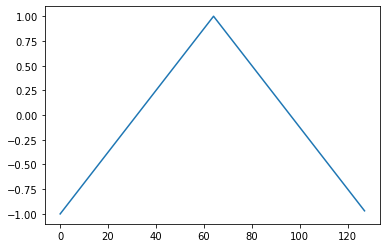

In [27]:
import matplotlib.pyplot as plt
plt.plot(tri_wavetable)

In [182]:
def reverb(x, impulse_in):
    print(impulse_in)
    fs, impulse = read(impulse_in)
    impulse = np.transpose(impulse)[0]

    #impulse = np.concatenate((impulse, np.zeros(len(x)-len(impulse))))
    impulse = impulse / np.max(impulse)
    x = np.real(impulse)

    fft_sig = scipy.fft.fft(x)
    fft_impulse = scipy.fft.fft(impulse)
    conv = fft_impulse * fft_sig
    return scipy.fft.ifft(conv)

In [183]:
reverb(play_list, "StNicolaesChurch.wav")

StNicolaesChurch.wav


array([-1.60035200e-04-2.06590069e-17j,  4.06673785e-04+2.42417342e-16j,
        1.75505413e-04+2.04919754e-16j, ...,
        1.59266812e-04-1.25783667e-16j,  1.31454891e-04+4.74414100e-16j,
        6.94548262e-05+3.52609603e-16j])